In [1]:
import os, sys, subprocess, pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
# sys.path.insert(0, '/home/shabalin/')
sys.path.insert(0, '/asap3/petra3/gpfs/common/p21.2/scripts/')
import py3DXRD
import experiment_settings
single_separator = "--------------------------------------------------------------"
double_separator = "=============================================================="


### SETTING THE SWEEPS AND OTHER OBJECTS:
def set_Geometry(det_num, material):
    GM = py3DXRD.Geometry() # initialization
    GM.load_par(directory = experiment_settings.path_gen + 'processed/calibration/',
                par_file = f'CeO2_avg_final.par') # load calibrated parameters
    GM.spline_file = None # Either None for perfect detector, or path to spline file
    GM.set_attr('distance'   , 714498.555)
    GM.set_attr('spacegroup' , material['spacegroup'])
    GM.set_attr('symmetry'   , material['symmetry'  ])
    GM.set_attr('unitcell'   , material['unitcell'  ])
    return GM


def set_SweepProcessor(i_load, i_slow, i_fast, det_num):
    default_xyz = [0, 0, 0]
    y_points = np.linspace(-3.5, 3.5, 71) # y-motor positions if needed
    
#     meta_key = path_gen + f'raw/fio/eh3scan_00029.fio'
#     meta_key = path_gen + f'raw/newMgAl102/{i_load}/{i_load}.log'
#     meta_key = path_gen + f'raw/macrotest/{i_load}/{i_fast:03d}_y1_{y_points[i_fast]:.4f}.fio'
    meta_key = experiment_settings.path_gen + f'raw/polypd002/{i_load}/{i_fast:03d}_y1_{y_points[i_fast]:.4f}.fio' # metadata of the sweep
    
    SP = experiment_settings.set_p212_sweep(i_slow, i_fast, det_num, default_xyz, meta_key) # this function usually don't need modifications
    
    if SP.sweep['stem'][-1] != '_': SP.sweep['stem'] += '_' # correct for possible mismatch between file stems in the sweep command and actual file names
    SP.processing['options'] = None # ('flip', 'r270') # detector flips if needed to be applied before those in geometry file
#     SP.directory = SP.directory.replace('035_y1_0.0000', '035_y1_0.0000_test') # if needed to modify the output directory (ie when the default one must not be overwritten)
    return SP


def set_GrainSpotter(material):
    GS = experiment_settings.set_grainspotter(material, domega=None)
#     GS.load_ini(ini_file = 'example.ini')

    GS.set_attr('tth_ranges'   , [ [8.0, 17.0] ] ) # 12.7]])
    GS.set_attr('ds_ranges'    , [] ) # [0.5, 1.0]]) # GV.ds_ranges)
    GS.set_attr('eta_ranges'   , [ [5, 85], [275, 355]] ) # GV.eta_ranges)
    GS.set_attr('omega_ranges' , [ [-179.5,  179.5]] ) # GV.omega_ranges)
    GS.set_attr('cuts'         , [ 12, 0.4,  0.4] )
    GS.set_attr('uncertainties', [0.2, 1.5,  1.0] ) # [sigma_tth sigma_eta sigma_omega] in degrees
    GS.set_attr('nsigmas'      , 1)
    GS.set_attr('eulerstep'    , 6)
    GS.set_attr('Nhkls_in_indexing', None)
    GS.set_attr('random', 10000)
    GS.set_attr('positionfit', True)
    return GS


def set_PolySim(grainspotter = None, material = None):
#     PS = py3DXRD.PolySim(directory = path_gen+"")
#     PS.load_inp(inp_file = "")
    PS = experiment_settings.set_polyxsim(grainspotter, material)
    PS.set_attr('inp_file', grainspotter.log_file.strip('.log'))
    PS.set_attr('beamflux', 1e12)
    PS.set_attr('beampol_factor', 1)
    PS.set_attr('beampol_direct', 0)
    PS.set_attr('stem'  , grainspotter.log_file.replace('.log', '_sim'))
    PS.set_attr('grains', [])
    PS.set_attr('omega_start', grainspotter.omega_ranges[0][0])
    PS.set_attr('omega_step' , abs(grainspotter.domega))
    PS.set_attr('omega_end'  , grainspotter.omega_ranges[-1][1])
    PS.set_attr('theta_min'  , grainspotter.tth_ranges[0][0]/2)
    PS.set_attr('theta_max'  , grainspotter.tth_ranges[-1][1]/2)
    PS.set_attr('no_grains'  , 1)
    PS.set_attr('gen_U'   , 0)
    PS.set_attr('gen_pos' , [0, 0])
    PS.set_attr('gen_eps' , [1, 0, 0 ,0, 0])
    PS.set_attr('gen_size', [0.0, 0.0, 0.0 ,0.0])
    PS.set_attr('make_image', 0)
    PS.set_attr('output', ['.tif', '.par', '.gve'])
    PS.set_attr('bg' , 0)
    PS.set_attr('psf', 0.7)
    PS.set_attr('peakshape', [1, 4, 0.5])
    return PS


def set_DATA(i_load, i_slow, i_fast, detectors, material):
    DATA = py3DXRD.DataAnalysis()
    DATA.set_attr('material', material)
    for det_num in detectors:
        SP = set_SweepProcessor(i_load, i_slow, i_fast, det_num)
        GM = set_Geometry(det_num, material)
        SP.set_attr('geometry', GM)
        DATA.add_to_attr('sweepProcessors', SP)
    DATA.set_attr('yml_det_order', [1])
    DATA.set_attr('directory'    , SP.directory)
    DATA.set_attr('name'         , f's{i_slow:03d}_f{i_fast:03d}_'+material['name'])
    DATA.set_attr('position'     , SP.position)
    DATA.set_attr('rotation'     , [0,0,0])
    if SP.log_meta:
        load_values = [ent['load'] for ent in SP.log_meta['entries']]
        DATA.set_attr('pressure', sum(load_values) / len(load_values))
    return DATA

--------------------------------------------------------------
SETTINGS LOADED!


LOAD = 1, TRANSLATIONS: slow = 0, fast = 35
Initialized DataAnalysis object.
--------------------------------------------------------------
Reading p212 fio file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/raw/polypd002/1/035_y1_0.0000.fio
file = 035_y1_0.0000.fio
directory = /asap3/petra3/gpfs/p21.2/2022/data/11013744/raw/polypd002/1/
detectors = []
command = fastsweep2 idrz1 360.0 0.0 --verbose --debug --addmg --colwidth 14 2:720/0.100,fidx=1,fname=frame.cbf --datadir /gpfs/current/raw/polypd002/1/035_y1_0.0000
energy = 38.0
idty1 = 0.0
idry1 = -0.09
idrz1 = 361.0105
idrx2 = -0.045998308851728814
idry2 = -1.052001920617178
idtx2 = -5.4272
idty2 = -1.6850999999999998
idtz2 = 7.248207088769032
In total 720 log entries with keys:
['idrz1(start)', 'idrz1(end)', 'idty1', 'idtz2', 'Varex_3', 'petracurrent', 'oh2_diode2', 'eh3_keith_curra', 'eh3_keith_currb', 'eh3_keith_1_curra', 'encoder3', 'dt', 'timestamp']
--------------------------------------------------------------
Initialized Geome

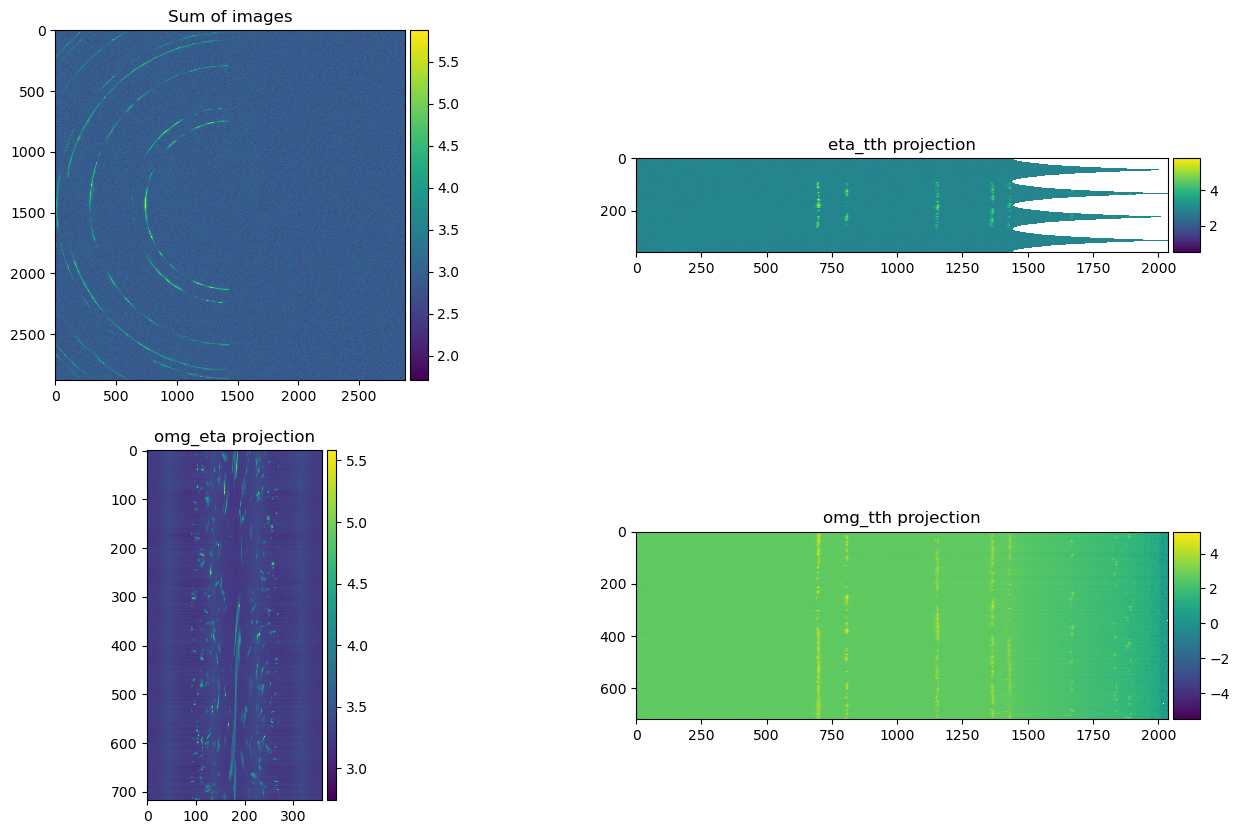

Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3_projs.png
Exporting data as: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3_t225.npz
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3_bckg.tif
Deleted old files.
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/projs_ranges/s000_f035_d3_proj_immax.tif
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/projs_ranges/s000_f035_d3_proj_imsum.tif
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/projs_ranges/s000_f035_d3_proj_etatth.tif
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/projs_ranges/s000_f0

Last line in the output:178.25 -179.553


--------------------------------------------------------------

INDEXING of s000_f035_d3:
Initialized PeakIndexer object.
Reading file:/asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3.flt
637 peaks loaded.
Generated PeakIndexer in /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/ named s000_f035_d3
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3.par
File already exist!
Overwriting...
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3.yml
File already exist!
Overwriting...
Running indexer on: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3.flt
Using par_file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_d3.par
178.25 -179.553
Resulted gvectors saved in: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polyp

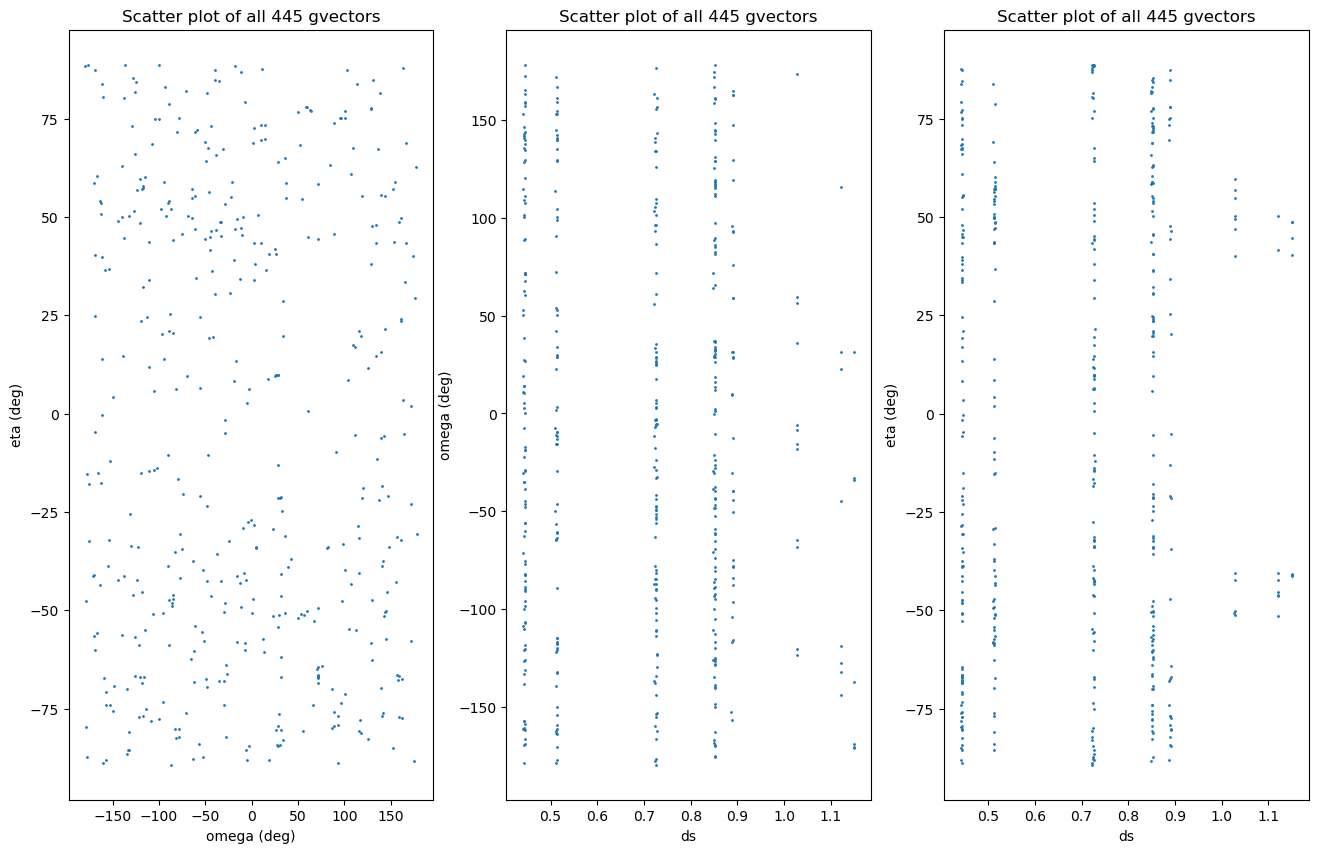

Saved projections: s000_f035_Pd_scatter.png
ds, n_peaks:  0.445, 0
ds, n_peaks:  0.514, 71
ds, n_peaks:  0.727, 93
ds, n_peaks:  0.852, 112
ds, n_peaks:  0.890, 35
ds, n_peaks:  1.028, 12
ds, n_peaks:  1.120, 8
ds, n_peaks:  1.149, 7


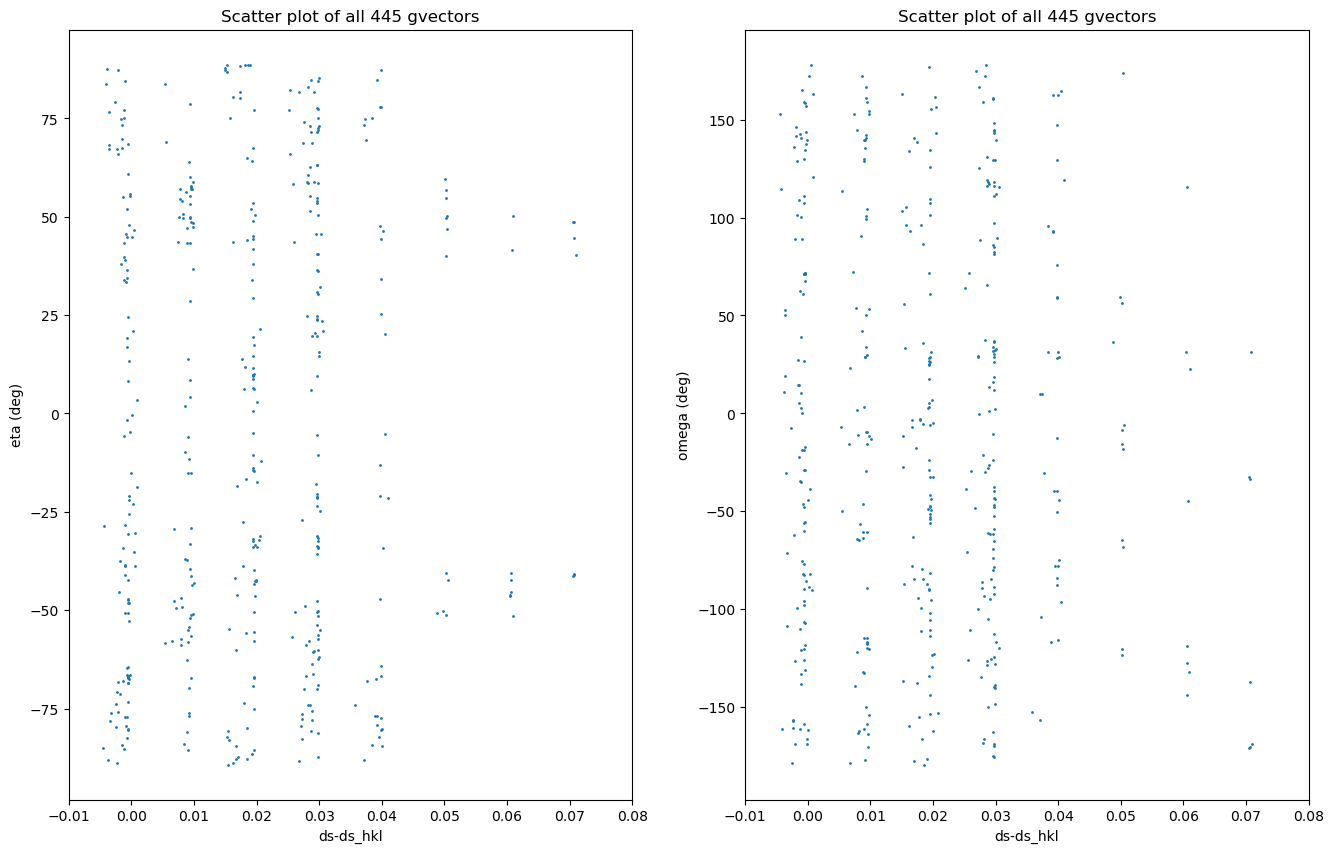

Saved eta_delta_ds: s000_f035_Pd_scatter_eta_delta_ds.png
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_Pd.gve
File already exist!
Overwriting...
Initialized GrainSpotter object.
--------------------------------------------------------------

RUNNING GRAINSPOTTER for s000_f035_Pd
Writing file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_Pd.ini
File already exist!
Overwriting...
Running grainspotter on: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_Pd.gve
Using ini_file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_Pd.ini
Last line in the output:Elapsed time: 0.13 sec = 0.00 min
Reading file: /asap3/petra3/gpfs/p21.2/2022/data/11013744/processed/polypd002/1/035_y1_0.0000/s000_f035_Pd.log
Initialized Grain object.
1 grains loaded.

Created PolySim object.
-------------------------------------------

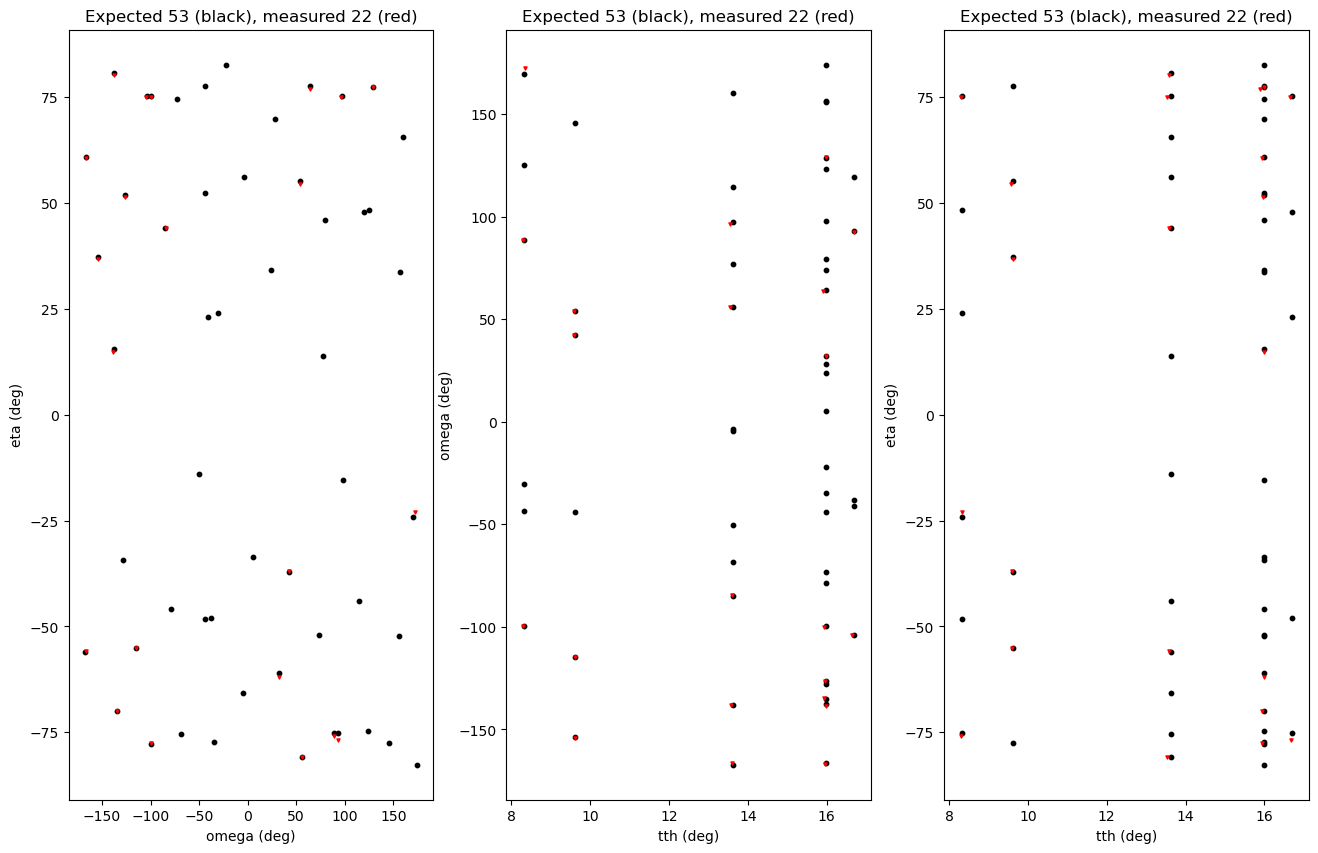

Saved measured vs expected: s000_f035_Pd_g1_scatter.png
DONE!


In [2]:
### SELECTING WHICH SWEEPS TO ANALYZE:
# loads_str = "1293  1305  1317 1419  1431  1443  1455  1467"
# print(single_separator+'\nLOADS:', [int(v) for v in loads_str.split()].sort())
load_states       = [1] # Indices of     loads to analyze
slow_translations = [0]                   #,1,2] # Indices of positions to analyze
fast_translations = list(range(0,71))     #,1,2,4,5,6,7,8] # Indices of positions to analyze
detectors         = [3]                   # Detector code to analyze (4 for Varex-4 etc)
material = experiment_settings.materials_table['Pd']

### LOADING RAW DATA. PEAKSERCHING, MERGING, APPLYING INSTRUMENT CONFIGURATION.
for i_load in load_states[:]: # 
    for i_slow in slow_translations[:]:     # (e.g. idty1).
        for i_fast in fast_translations[35:36]: # (e.g. idtz2).
            print(double_separator + f'\nLOAD = {i_load}, TRANSLATIONS: slow = {i_slow}, fast = {i_fast}')
            
            DATA = set_DATA(i_load, i_slow, i_fast, detectors, material)
            
            DATA.process_images(frames = 'all', thr = 'auto')
            DATA.peaksearch(peaksearch_thresholds = 'auto', peakmerge_thresholds = 'auto', min_peak_dist = 10)
            pickle.dump(DATA, open(DATA.directory+DATA.name+"_DATA.p","wb") )
            
#             DATA = pickle.load(open(DATA.directory+DATA.name+"_DATA.p","rb") )
            DATA.index(move_det_xyz_mm = [0, -1*DATA.position[1], 0])
            DATA.evaluateGvectors(tth_gap=0.5, ds_gap=0.1, eta_gap=1)
            DATA.searchGrains(grainSpotter = set_GrainSpotter(material))
            pickle.dump(DATA, open(DATA.directory+DATA.name+"_DATA.p","wb") )
            
#             DATA = pickle.load(open(DATA.directory+DATA.name+"_DATA.p","rb") )
            DATA.runPolyXSim(polyxsim = set_PolySim(DATA.grainSpotter))
print('DONE!')

In [ ]:
list_DATApaths = []
for i_load in load_states[:]: # 
    for i_slow in slow_translations[:]:     # (e.g. idty1).
        for i_fast in fast_translations[0:1]: # (e.g. idtz2).
            print(double_separator + f'\nLOAD = {i_load}, TRANSLATIONS: slow = {i_slow}, fast = {i_fast}')
            DATA = set_DATA(i_load, i_slow, i_fast, detectors, material)
            list_DATApaths.append(DATA.directory+DATA.name+"_DATA.p")

list_DATApaths = [p for n, p in enumerate(list_DATApaths) if p not in list_DATApaths[:n]]
print(list_DATApaths)

from py3DXRD.DataAnalysis import plot_sinogram, set_MultiDATA
plot_sinogram(list_DATApaths)
DATA_ALL = set_MultiDATA(list_DATApaths, 35)

DATA_ALL.evaluateGvectors(tth_gap=0.5, ds_gap=0.1, eta_gap=1)
DATA_ALL.searchGrains(grainSpotter = set_grainspotter())
pickle.dump(DATA_ALL, open(DATA_ALL.directory+DATA_ALL.name+"_DATA.p","wb") )
# DATA.runPolyXSim(polyxsim = set_polyxsim(DATA_ALL.grainSpotter, material = DATA_ALL.material))

In [ ]:
GM = Geometry(directory = '/asap3/petra3/gpfs/p21.2/2020/commissioning/c20200518_000_ruby02/processed/new_geom_test/images5/')
GM.load_yml(yml_file ='ruby.yml')

In [ ]:
# SP = DATA.sweepProcessors[0]
# SP.projs['immax']
self = DATA.sweepProcessors[0]
import tifffile
import scipy, polarTransform
path = self.directory+'projs_ranges/'+self.name
path.replace(path.split('/')[-1], '')
immax = tifffile.imread(path+"_proj_immax.tif")
cen_pos = [self.geometry.y_center, self.geometry.z_center]
self.projs = {'immax':immax}

In [ ]:
from lmfit.models import LinearModel, GaussianModel, PseudoVoigtModel, LorentzianModel
immax_inpolar, ptSettings = polarTransform.convertToPolarImage(
    self.projs['immax'],
    center=[self.geometry.y_center, self.geometry.z_center]) # max projection in polar coordinates

immax_inpolar[immax_inpolar < 3] = np.nan
tth_immax_profile = np.nanpercentile(immax_inpolar, 99.9, 0) # peaks for each tth
tth_immax_profile[tth_immax_profile < 3] = np.nan
tth_immax_sorted = np.sort(tth_immax_profile)
tth_cleaned = [x for x in tth_immax_sorted if not np.isnan(x)][10:-10] # first 10 and the last 10 

grad = np.gradient( scipy.ndimage.gaussian_filter1d(tth_cleaned, 50) ) # gradient profile to eliminate the bad regions in the beginning and end
pks_ind, pks_heights = scipy.signal.find_peaks(grad, height = 0.1)
if len(pks_ind) > 1:
    tth_cleaned = tth_cleaned[pks_ind[0]:pks_ind[-1]] # before the first peaks the intensities are some irregular noise or artifacts. After the last peak it is also not relevant.

x = np.linspace(0, len(tth_cleaned), num = len(tth_cleaned))
y = np.asarray(tth_cleaned)

pseudo_voigt = PseudoVoigtModel(prefix = 'PseudoVoigtModel_')
pars = pseudo_voigt.guess(y, x = x)

lin_mod = LinearModel(prefix = 'Linear_')
pars.update(lin_mod.make_params())

mod = pseudo_voigt +  lin_mod

init = mod.eval(pars, x = x)
out  = mod.fit(y, pars, x = x)

diff = scipy.ndimage.gaussian_filter1d(out.best_fit - y, 30)
diff_pks_ind, diff_pks_heights = scipy.signal.find_peaks(diff, height = 3)

gradgrad = np.gradient(np.gradient( scipy.ndimage.gaussian_filter1d(tth_cleaned, 30) ))# gradient profile to eliminate the bad regions in the beginning and end
pks_ind, pks_heights = scipy.signal.find_peaks(gradgrad, height = 0.001)

dists = [abs(p - diff_pks_ind[0]) for p in pks_ind] # searching fro the closest gradgrad peak 
base_thr = tth_cleaned[ pks_ind[np.argmin(dists)]]
base_thr = y[diff_pks_ind[0]]

thresholds = base_thr*np.asarray( [2028, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1] )
thresholds = np.asarray([t for t in thresholds if t < np.max(self.projs['immax'])/2])
self.set_attr('thresholds', [int(np.round(t)) for t in thresholds])


fig = plt.figure(figsize=(16, 10))
sub = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_profile, label='tth_immax_profile')
plt.legend()

sub = fig.add_subplot(222) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_sorted, label='tth_immax_sorted')
plt.plot(tth_cleaned, label='tth_cleaned')
# plt.ylim([0, 1000])
# plt.xlim([4000, 6000])
plt.legend()

sub = fig.add_subplot(223) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_sorted, label='tth_immax_sorted')
plt.plot(tth_cleaned, label='tth_cleaned')
plt.xlim([0, 200])
plt.ylim([0, 200])
plt.legend()

sub = fig.add_subplot(224) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_sorted, label='tth_immax_sorted')
plt.plot(tth_cleaned, label='tth_cleaned')
plt.xlim([2500, 2800])
plt.ylim([0, 700])
plt.legend()

# print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y, label = 'Data')
axes[1].plot(x, comps['PseudoVoigtModel_'], '--', label='PseudoVoigt component')
axes[1].plot(x, comps['Linear_'], '--', label='Linear component')
axes[1].legend()
plt.xlim([4000, 5300])
plt.ylim([-1000, 5000])

fig = plt.figure(figsize=(16, 10))
sub = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
plt.plot(out.best_fit - y, label = 'best_fit - data')
plt.plot(diff, label = 'Smoothed: best_fit - data')
plt.xlim([4200, 4500])
plt.ylim([200, 500])
plt.legend()

sub = fig.add_subplot(222) # instead of plt.subplot(2, 2, 1)
plt.plot(gradgrad, label='gradgrad')
plt.xlim([4200, 4500])
plt.ylim([-0.01, 0.04])
plt.legend()

sub = fig.add_subplot(224) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_cleaned, label='tth_cleaned')
plt.xlim([4200, 4500])
plt.ylim([400, 700])
plt.legend()

print("Gradgrad peaks coordinates:", pks_ind)
print("Closest:", pks_ind[np.argmin(dists)], "=> I = ", tth_cleaned[ pks_ind[np.argmin(dists)]])

In [ ]:
fig = plt.figure(figsize=(16, 10))
sub = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_profile, label='tth_immax_profile')
plt.legend()

sub = fig.add_subplot(222) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_sorted, label='tth_immax_sorted')
plt.plot(tth_cleaned, label='tth_cleaned')
# plt.ylim([0, 1000])
# plt.xlim([4000, 6000])
plt.legend()

sub = fig.add_subplot(223) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_sorted, label='tth_immax_sorted')
plt.plot(tth_cleaned, label='tth_cleaned')
plt.xlim([0, 100])
plt.ylim([0, 20])
plt.legend()

sub = fig.add_subplot(224) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_immax_sorted, label='tth_immax_sorted')
plt.plot(tth_cleaned, label='tth_cleaned')
plt.xlim([00, 2400])
plt.ylim([10, 20])
plt.legend()

# print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y, label = 'Data')
axes[1].plot(x, comps['PseudoVoigtModel_'], '--', label='PseudoVoigt component')
axes[1].plot(x, comps['Linear_'], '--', label='Linear component')
axes[1].legend()
plt.xlim([2400, 2800])
plt.ylim([-1000, 5000])

fig = plt.figure(figsize=(16, 10))
sub = fig.add_subplot(221) # instead of plt.subplot(2, 2, 1)
plt.plot(out.best_fit - y, label = 'best_fit - data')
plt.plot(diff, label = 'Smoothed: best_fit - data')
plt.xlim([1500, 2800])
plt.ylim([-30, -20])
plt.legend()

sub = fig.add_subplot(222) # instead of plt.subplot(2, 2, 1)
plt.plot(gradgrad, label='gradgrad')
plt.xlim([1500, 2800])
plt.ylim([0, 0.01])
plt.legend()

sub = fig.add_subplot(224) # instead of plt.subplot(2, 2, 1)
plt.plot(tth_cleaned, label='tth_cleaned')
plt.xlim([2400, 2800])
plt.ylim([0, 700])
plt.legend()

print("Gradgrad peaks coordinates:", pks_ind)
print("Closest:", pks_ind[np.argmin(dists)], "=> I = ", tth_cleaned[ pks_ind[np.argmin(dists)]])

In [ ]:
DATA.peaksearch(peaksearch_thresholds = thresholds, peakmerge_thresholds = thresholds, min_peak_dist = 10)
pickle.dump(DATA, open(DATA.directory+DATA.name+"_DATA.p","wb") )

#             DATA = pickle.load(open(DATA.directory+DATA.name+"_DATA.p","rb") )
DATA.index(move_det_xyz_mm = [0, -1*DATA.position[1], 0])
DATA.evaluateGvectors(tth_gap=0.5, ds_gap=0.1, eta_gap=1)
DATA.searchGrains(grainSpotter = set_GrainSpotter(material))
pickle.dump(DATA, open(DATA.directory+DATA.name+"_DATA.p","wb") )

#             DATA = pickle.load(open(DATA.directory+DATA.name+"_DATA.p","rb") )
DATA.runPolyXSim(polyxsim = set_PolySim(DATA.grainSpotter))

In [ ]:
thresholds = base_thr*np.asarray( [2028, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1, 1/2] )
thresholds = np.asarray([t for t in thresholds if t > 9 and t < np.max(self.projs['immax'])/2]) # reasonable range is [9 counts, max_intentsity/2] 
thresholds = [int(np.round(t)) for t in thresholds]

In [ ]:
base_thr
thresholds

In [8]:
ll = [1892, 1904, 1910, 1916, 1922, 1928, 1934, 1940, 1946,
      1952, 1958, 1964, 1970, 1976, 1982, 1988,1994, 2000, 2006, 2012, 2018, 2024, 2030, 2036,
      2042, 2048, 2054, 2060, 2066, 2072, 2078, 2084, 2090] # Indices of     loads to analyze
ll

[1892,
 1904,
 1910,
 1916,
 1922,
 1928,
 1934,
 1940,
 1946,
 1952,
 1958,
 1964,
 1970,
 1976,
 1982,
 1988,
 1994,
 2000,
 2006,
 2012,
 2018,
 2024,
 2030,
 2036,
 2042,
 2048,
 2054,
 2060,
 2066,
 2072,
 2078,
 2084,
 2090]

In [6]:
a = "kj" +"hg"
a

'kjhg'